# Git Repository Bringup

In [64]:
!git version

git version 2.34.1
time: 105 ms (started: 2023-09-25 17:49:30 +00:00)


In [65]:
!git clone https://github.com/ramwtz/data-science-project.git

fatal: destination path 'data-science-project' already exists and is not an empty directory.
time: 728 ms (started: 2023-09-25 17:49:30 +00:00)


In [66]:
!ls

data-science-project  drive  sample_data
time: 107 ms (started: 2023-09-25 17:49:31 +00:00)


In [67]:
%cd data-science-project/

/content/data-science-project
time: 3.66 ms (started: 2023-09-25 17:49:31 +00:00)


In [68]:
!pwd

/content/data-science-project
time: 104 ms (started: 2023-09-25 17:49:31 +00:00)


In [69]:
!git switch dev/ram

Already on 'dev/ram'
Your branch is up to date with 'origin/dev/ram'.
time: 106 ms (started: 2023-09-25 17:49:31 +00:00)


In [70]:
%cd ..

/content
time: 1.52 ms (started: 2023-09-25 17:49:31 +00:00)


# Basic Bringup for Remote Envrionment

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.85 s (started: 2023-09-25 17:49:34 +00:00)


In [72]:
# Necessary packages for this nb
!pip install --quiet -r '/content/data-science-project/dependencies.txt'

time: 7.24 s (started: 2023-09-25 17:49:36 +00:00)


# Initialize Env

In [73]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import librosa as lbrs
import IPython
import IPython.display as ipd
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers, callbacks
from sklearn import metrics
from scipy import fft

# Configs
%load_ext autotime
tqdm.pandas()

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.75 ms (started: 2023-09-25 17:49:47 +00:00)


In [74]:
gen_data_dir = os.path.join('drive', 'MyDrive', 'project', 'data')
calls_dir = os.path.join(gen_data_dir, 'calls')
new_data_dir = os.path.join(gen_data_dir, 'new')

#
metadata_path = os.path.join(calls_dir, '911_first6sec', '911_metadata_6sec.csv')

time: 1.33 ms (started: 2023-09-25 17:49:47 +00:00)


In [75]:
def get_path_from_filename(audio_file_name):
    type_dir, file_name = audio_file_name.split('/')
    return os.path.join(calls_dir, type_dir, file_name)

time: 481 µs (started: 2023-09-25 17:49:47 +00:00)


In [76]:
def create_audio_series(audio_file_name):
    audio_file_path = get_path_from_filename(audio_file_name)
    data, sample_rate = lbrs.load(audio_file_path)
    return audio_file_name, data, sample_rate

time: 436 µs (started: 2023-09-25 17:49:47 +00:00)


# MFCC Model - First Attempt
For our first model we will use [this paper](https://ietresearch.onlinelibrary.wiley.com/doi/full/10.1049/tje2.12082) on speech recognition by Rakibul Hasan, Mahbub Hasan & Zakir Hossain,  as a reference point, although dpeech recognition is not the intent, the model we are attempting to build is tangentialially related, and so this is a good reference point to start from.

## Initial Build

In [78]:
# load metadata from csv to a pandas dataframe
metadata_df = pd.read_csv(metadata_path)

time: 32.8 ms (started: 2023-09-25 17:49:55 +00:00)


In [79]:
print(metadata_df.count())

id                 710
event_id           710
link               710
title              710
date               689
state              702
deaths             709
potential_death    709
false_alarm        709
description        701
deaths_binary      710
break              710
filename           710
dtype: int64
time: 19.9 ms (started: 2023-09-25 17:49:56 +00:00)


In [80]:
# TODO (ram): need to find the duplicates
metadata_df.drop_duplicates(subset=['filename'], inplace=True)
metadata_df.reset_index(drop=True, inplace=True)
print(metadata_df.count())

id                 707
event_id           707
link               707
title              707
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      707
break              707
filename           707
dtype: int64
time: 15.6 ms (started: 2023-09-25 17:49:56 +00:00)


In [81]:
metadata_df[metadata_df['deaths'].isnull()]

,id,event_id,link,title,date,state,deaths,potential_death,false_alarm,description,deaths_binary,break,filename
39,39,54,https://web.archive.org/web/20150417085342/htt...,Boat rescue #1 – Minn.,NaN,NaN,NaN,NaN,NaN,NaN,0,2.0,911_first6sec/call_54_0.wav


time: 823 ms (started: 2023-09-25 17:49:56 +00:00)


In [82]:
# TODO (Ram): maybe we can tag this ourselves
metadata_df = metadata_df[metadata_df['deaths'].notna()]
metadata_df.reset_index(drop=True, inplace=True)
print(metadata_df.count())

id                 706
event_id           706
link               706
title              706
date               686
state              699
deaths             706
potential_death    706
false_alarm        706
description        699
deaths_binary      706
break              706
filename           706
dtype: int64
time: 12.6 ms (started: 2023-09-25 17:49:57 +00:00)


## The Models features
We will use Mel-frequency cepstral coefficients as our features, as is common in speech recognition (but not exclusive to).

The MFCCs are essentialy an extension of the STFT that we've seen in the previous section, in that the MFCCs are computed by breaking up the signal into windows and computing the DFT for each window, but expands upon this by mapping the signal to the mel-scale, taking the log of mapping and applying a discrete cosine transform, with the MFCC being the magnitude of the resulting spectrum.

In [174]:
def mfcc_feature_extractor(filename, n_mfcc=13, n_fft=512, hop_length=124):
  _, data, sr = create_audio_series(filename)
  mfcc = lbrs.feature.mfcc(
      y=data, sr=sr, n_mfcc=n_mfcc,
      n_fft=n_fft, hop_length=hop_length
      )

  return np.mean(mfcc.T, axis=0)

time: 885 µs (started: 2023-09-25 19:14:35 +00:00)


In [175]:
# paths
filenames = metadata_df['filename']
features = filenames.progress_apply(mfcc_feature_extractor, n_mfcc=25)
features.rename('features', inplace=True)

features_named = pd.concat([filenames, features], axis=1)
features_named.head(10)

100%|██████████| 706/706 [00:32<00:00, 21.59it/s]


,filename,features
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,..."
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544..."
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ..."
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ..."
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,..."
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2...."
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195..."
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,..."
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ..."
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,..."


time: 32.7 s (started: 2023-09-25 19:14:44 +00:00)


In [176]:
print(f'Number of samples: {len(features)}')
print(f'Number of MFCCs per sample: {len(features[0])}')

Number of samples: 706
Number of MFCCs per sample: 25
time: 1.28 ms (started: 2023-09-25 19:15:19 +00:00)


 ## The Models Classes

In [177]:
# Create classification
classes_named = metadata_df[['filename', 'deaths_binary']]

classes_named = classes_named.rename(
  columns={'deaths_binary': 'resulted_in_deaths'})

# Create combied dataframe
features_classes = pd.merge(features_named, classes_named)
features_classes.head(10)

,filename,features,resulted_in_deaths
0,911_first6sec/call_2_0.wav,"[-496.04065, 136.32658, -38.824547, -2.956653,...",1
1,911_first6sec/call_8_0.wav,"[-542.26483, 113.492096, -54.898445, -16.93544...",1
2,911_first6sec/call_9_0.wav,"[-469.10492, 144.50133, -53.16924, -35.66156, ...",0
3,911_first6sec/call_10_0.wav,"[-461.7921, 102.00011, 4.2778754, -3.2980382, ...",1
4,911_first6sec/call_11_0.wav,"[-388.4136, 191.76454, -68.483246, -28.393341,...",0
5,911_first6sec/call_12_0.wav,"[-366.632, 123.76255, -8.727576, -9.830455, 2....",1
6,911_first6sec/call_13_0.wav,"[-328.94275, 173.40773, -122.68931, -22.340195...",1
7,911_first6sec/call_15_0.wav,"[-388.2811, 92.171074, 0.91390646, -14.596169,...",1
8,911_first6sec/call_16_0.wav,"[-500.0724, 121.41379, -37.134045, 13.093015, ...",1
9,911_first6sec/call_17_0.wav,"[-335.3681, 180.51752, -75.116455, -6.7831354,...",1


time: 26.9 ms (started: 2023-09-25 19:15:22 +00:00)


In [178]:
# save to csv in new data directory
features_classes_path = os.path.join(new_data_dir, 'features_classes.csv')
features_classes.to_csv(features_classes_path, encoding='utf-8', index=False)

time: 302 ms (started: 2023-09-25 19:15:25 +00:00)


## Create Feature and Class series

In [189]:
features = np.array(features_classes['features'].tolist())
classes = np.array(features_classes['resulted_in_deaths'].tolist())

time: 2.65 ms (started: 2023-09-25 19:18:08 +00:00)


In [190]:
print(features.shape)

(706, 25)
time: 1.26 ms (started: 2023-09-25 19:18:09 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features, classes ,test_size=0.25, shuffle=True, stratify=classes,
    random_state=0
    )

time: 2.55 ms (started: 2023-09-25 19:19:14 +00:00)


## Train - Defs

In [145]:
checkpointer = callbacks.ModelCheckpoint(
    filepath='saved_models/audio_classification.hdf5',
    verbose=1, save_best_only=True)

time: 848 µs (started: 2023-09-25 18:39:06 +00:00)


## Train

In [336]:
def create_4hl_model(input_shape, optimizer_name='Adam', learning_rate=0.0005,
                     epochs=500, activation='tanh'):
  model = models.Sequential()
  model.add(layers.InputLayer(input_shape=input_shape))
  model.add(layers.Dense(units=128, activation=activation))
  model.add(layers.Dense(units=64, activation=activation))
  model.add(layers.Dense(units=32, activation=activation))
  model.add(layers.Dense(units=16, activation=activation))
  model.add(layers.Dense(units=2, activation='softmax'))

  opt = getattr(optimizers, optimizer_name)
  model.compile(
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    optimizer=opt(learning_rate))

  return model

time: 1.21 ms (started: 2023-09-25 21:09:24 +00:00)


In [466]:
input_shape = (features.shape[1],)
optimizer_name = 'Adam'
learning_rate = 0.0001
epochs = 500

model = create_4hl_model(input_shape, optimizer_name, learning_rate, epochs)

time: 471 ms (started: 2023-09-25 22:21:57 +00:00)


In [467]:
# define callbacks
reduce_lr_callback = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=0.000005, verbose=1)

earlystopping = callbacks.EarlyStopping(
    monitor="loss", patience=50, restore_best_weights=True,
    verbose=1)

time: 800 µs (started: 2023-09-25 22:21:59 +00:00)


In [468]:
train_res  = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[
        # checkpointer,
        earlystopping,
        reduce_lr_callback
        ],
    verbose=1
    )
print()

Epoch 1/500
17/17 [==============================] - 1s 16ms/step - loss: 0.6871 - accuracy: 0.5690 - val_loss: 0.6856 - val_accuracy: 0.5932 - lr: 1.0000e-04
Epoch 2/500
17/17 [==============================] - 0s 5ms/step - loss: 0.6781 - accuracy: 0.5917 - val_loss: 0.6841 - val_accuracy: 0.5932 - lr: 1.0000e-04
Epoch 3/500
17/17 [==============================] - 0s 4ms/step - loss: 0.6762 - accuracy: 0.5879 - val_loss: 0.6841 - val_accuracy: 0.5932 - lr: 1.0000e-04
Epoch 4/500
17/17 [==============================] - 0s 5ms/step - loss: 0.6701 - accuracy: 0.5917 - val_loss: 0.6844 - val_accuracy: 0.5932 - lr: 1.0000e-04
Epoch 5/500
17/17 [==============================] - 0s 5ms/step - loss: 0.6692 - accuracy: 0.5955 - val_loss: 0.6852 - val_accuracy: 0.5876 - lr: 1.0000e-04
Epoch 6/500
17/17 [==============================] - 0s 4ms/step - loss: 0.6664 - accuracy: 0.5936 - val_loss: 0.6865 - val_accuracy: 0.5932 - lr: 1.0000e-04
Epoch 7/500
17/17 [==============================] 

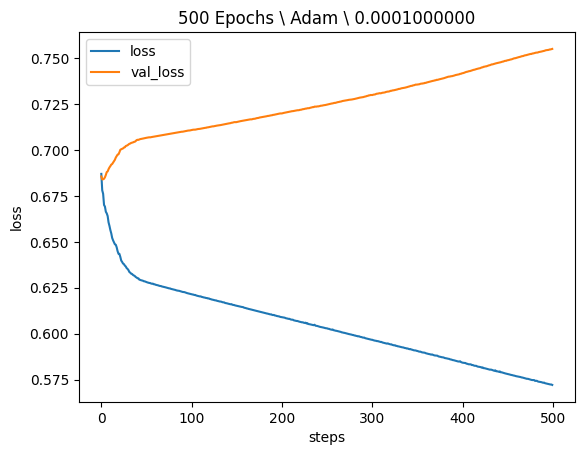

time: 306 ms (started: 2023-09-25 22:23:34 +00:00)


In [469]:
cnn_feats_history_pd = pd.DataFrame(train_res.history)
title = f'{epochs} Epochs \ {optimizer_name} \ {learning_rate:.10f}'
cnn_feats_history_pd[['loss','val_loss']].plot(title=title,xlabel='steps', ylabel='loss')
plt.show()

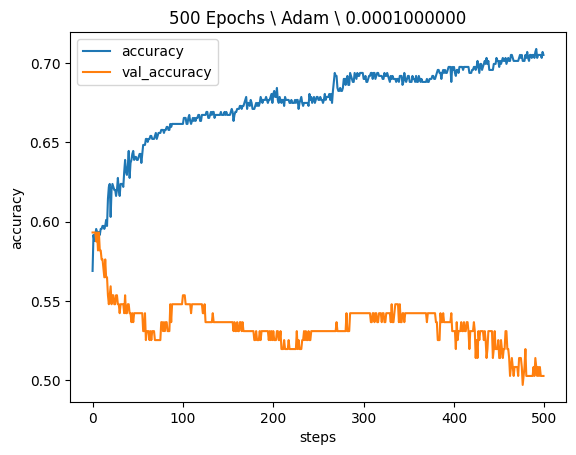

time: 592 ms (started: 2023-09-25 22:23:40 +00:00)


In [470]:
title = f'{epochs} Epochs \ {optimizer_name} \ {learning_rate:.10f}'
cnn_feats_history_pd[['accuracy','val_accuracy']].plot(title=title,xlabel='steps', ylabel='accuracy')
plt.show()

In [471]:
test_accuracy = model.evaluate(X_test, y_test,
  # batch_size=num_batch_size,
  verbose=0)
print(test_accuracy)

[0.7551520466804504, 0.5028248429298401]
time: 118 ms (started: 2023-09-25 22:23:44 +00:00)


In [472]:
y_probs = model.predict(X_test)

6/6 [==============================] - 0s 3ms/step
time: 245 ms (started: 2023-09-25 22:23:48 +00:00)


In [473]:
y_predicted = np.argmax(y_probs, axis=-1)
print(y_predicted)

[1 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0
 1 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1
 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0
 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1
 1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1]
time: 1.51 ms (started: 2023-09-25 22:23:54 +00:00)


In [474]:
# notice the y_test and not cat
print(metrics.classification_report(y_test, y_predicted, digits=4, target_names=['no-death','death']))

              precision    recall  f1-score   support

    no-death     0.3400    0.2361    0.2787        72
       death     0.5669    0.6857    0.6207       105

    accuracy                         0.5028       177
   macro avg     0.4535    0.4609    0.4497       177
weighted avg     0.4746    0.5028    0.4816       177

time: 16.3 ms (started: 2023-09-25 22:23:55 +00:00)


In [459]:
deep_feats_cm = metrics.confusion_matrix(y_test, y_predicted)

time: 2.98 ms (started: 2023-09-25 22:18:42 +00:00)


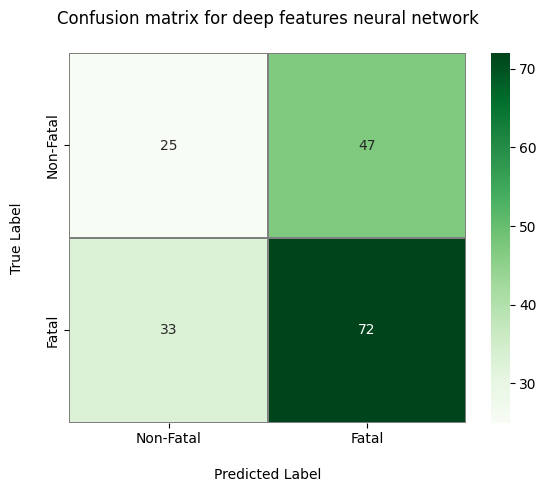

Sensitivity :  0.3472222222222222
Specificity :  0.6857142857142857
time: 259 ms (started: 2023-09-25 22:18:44 +00:00)


In [460]:
ax = sns.heatmap(deep_feats_cm, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt='g')

ax.set_xlabel("\nPredicted Label")
ax.set_ylabel("True Label\n")

ax.xaxis.set_ticklabels(['Non-Fatal','Fatal'])
ax.yaxis.set_ticklabels(['Non-Fatal','Fatal'])


ax.set_title("Confusion matrix for deep features neural network\n")

plt.show()

sensitivity1 = deep_feats_cm[0,0]/(deep_feats_cm[0,0]+deep_feats_cm[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = deep_feats_cm[1,1]/(deep_feats_cm[1,0]+deep_feats_cm[1,1])
print('Specificity : ', specificity1)

# Model Train - Evened-out Classes

In [ ]:
classes = classes_named['resulted_in_deaths']
print(classes.value_counts())

1    418
0    288
Name: resulted_in_deaths, dtype: int64
time: 4.8 ms (started: 2023-09-25 17:54:04 +00:00)


In [ ]:
# Create classification
num_of_non_death = classes.value_counts()[0]
t = classes[classes == 1].sample(num_of_non_death)
evened_classes = pd.concat([t, classes[classes == 0]])
print(evened_classes.value_counts())
evened_classes

1    288
0    288
Name: resulted_in_deaths, dtype: int64


415    1
340    1
540    1
195    1
311    1
      ..
687    0
693    0
701    0
702    0
705    0
Name: resulted_in_deaths, Length: 576, dtype: int64

time: 1.55 s (started: 2023-09-25 17:55:38 +00:00)
